In [132]:
# Load the data from the Streaking  preprocessing .h5 file
# Sunnyvale, Yusong, 06/15/2025

In [133]:
import os
import sys
sys.path.append('/sdf/data/lcls/ds/ued_testfac/scratch/python_packages')
import time
import numpy as np
import h5py
import matplotlib as mpl
import matplotlib.pyplot as plt
import configparser
import argparse
import scipy.ndimage.measurements as smt

from scipy.ndimage import gaussian_filter as gf
from scipy.optimize import curve_fit
from scipy.special import erf
from psana import DataSource
from numba import jit, njit
from ued_LCLSII_DAQ_utilities import *
from UEDePixTools import *
from tqdm import tqdm
from PIL import Image

# %matplotlib widget

In [134]:
# Define the function with two Gaussians
def center_of_mass(Distribution,opetor): # Define Center of Mass function 
    output = np.sum(opetor*Distribution,axis=0)/np.sum(Distribution,axis=0)
    return output
    
def gaussian(x, amp, mean, sigma): # Define the Gaussian function
    return amp * np.exp(-(x - mean)**2 / (2 * sigma**2))

def error_function(x, a, b, c,y0): # Define the error function model
    return a * erf(b * (x - c))+y0

In [135]:
# Check a single and pring out keys
exp = 'ued1011086'
run = 25
with h5py.File("/sdf/scratch/lcls/ds/ued/%s/scratch/preproc/v2/run_%i.h5" % (exp, run), 'r') as raw:
    for i_key in raw.keys():
        print(i_key)

img_com_1
img_com_2
img_cut
img_inte_1
img_inte_2
step_value
timestamp


In [136]:
runs = np.array([run])
print('Load .h5 run of'+str(runs))
tic = time.time()
for i_run, run in enumerate(runs):
    hf = h5py.File("/sdf/scratch/lcls/ds/ued/%s/scratch/preproc/v2/run_%i.h5" % (exp, run), 'r')
    print(f'Loading run: {run}')

    # Extract the .h5 infors
    timestamp  = np.argsort(np.array(hf.get('timestamp')))
    shot_id    = np.arange(0,len(timestamp))[timestamp]
    scan_var_1 = np.array(hf.get('step_value'))[timestamp].flatten() # the photon energy
    img_inte_1 = np.array(hf.get('img_inte_1'))[timestamp]
    img_inte_2 = np.array(hf.get('img_inte_2'))[timestamp]
    img_com_1  = np.array(hf.get('img_com_1'))[timestamp]
    img_com_2  = np.array(hf.get('img_com_2'))[timestamp]
    img_cut    = np.array(hf.get('img_cut'))[timestamp]

    if i_run == 0:
        timestamp_runs  = timestamp
        shot_id_runs    = shot_id
        scan_var_1_runs = scan_var_1
        img_inte_1_runs = img_inte_1
        img_inte_2_runs = img_inte_2
        img_com_1_runs  = img_com_1
        img_com_2_runs  = img_com_2
        img_cut_runs    = img_cut

    else:
        timestamp_runs  = np.concatenate((timestamp_runs,timestamp),axis=0)
        shot_id_runs    = np.concatenate((shot_id_runs,shot_id),axis=0)
        img_inte_1_runs = np.concatenate((img_inte_1_runs,img_inte_1),axis=0)
        img_inte_2_runs = np.concatenate((img_inte_2_runs,img_inte_2),axis=0)
        scan_var_1_runs = np.concatenate((scan_var_1_runs,scan_var_1),axis=0)
        img_com_1_runs  = np.concatenate((img_com_1_runs,img_com_1),axis=0)
        img_com_2_runs  = np.concatenate((img_com_2_runs,img_com_2),axis=0)
        img_cut_runs    = np.concatenate((img_cut_runs,img_cut),axis=0)

toc = time.time()
print(f'Load time : {np.round(toc-tic)} seconds')
delayss = np.unique(scan_var_1_runs) # The scan
print('Total steps of PV values are: '+str(delayss.shape[0]))
img_cut_shape = np.shape(img_cut_runs)

Load .h5 run of[25]
Loading run: 25
Load time : 0.0 seconds
Total steps of PV values are: 51


In [137]:
# Plot the single short images


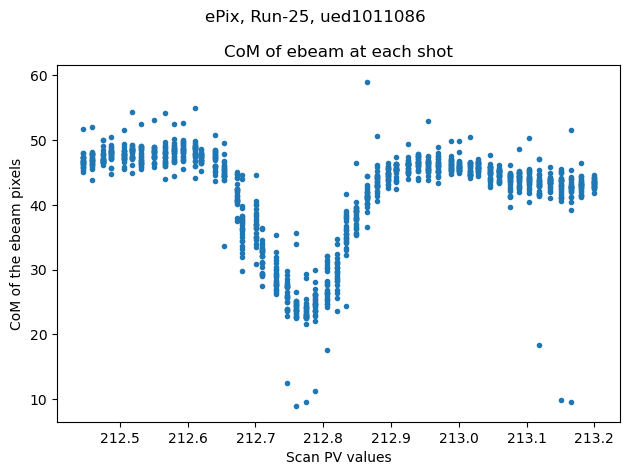

In [138]:
plt.figure()
plt.suptitle('ePix, Run-'+str(run)+', '+str(exp))
plt.plot(scan_var_1_runs[(img_com_2_runs>5)&(img_com_2_runs<60)], img_com_2_runs[(img_com_2_runs>5)&(img_com_2_runs<60)],'.')
plt.xlabel('Scan PV values');plt.ylabel('CoM of the ebeam pixels');
plt.title('CoM of ebeam at each shot');
plt.tight_layout()
plt.show()

In [139]:
# Averaging the ingegrated signal at each PV scan vales
img_runs_ave = []
img_inte_2_runs_ave = []
img_inte_2_runs_coms_ave  = []
for i_delay, delay in enumerate(delayss):
    flt_step = (scan_var_1_runs == delay)&(img_com_2_runs>0)&(img_com_2_runs<60)
    img_runs_ave.append(img_cut[flt_step].mean(axis=0))
    img_inte_2_runs_ave.append(img_inte_2_runs[flt_step].mean(axis=0)) # ave trace
    img_inte_2_runs_coms_ave.append(img_com_2_runs[flt_step].mean())
img_inte_2_runs_coms_ave = np.array(img_inte_2_runs_coms_ave)
img_inte_2_runs_ave      = np.array(img_inte_2_runs_ave)
img_runs_ave             = np.array(img_runs_ave)

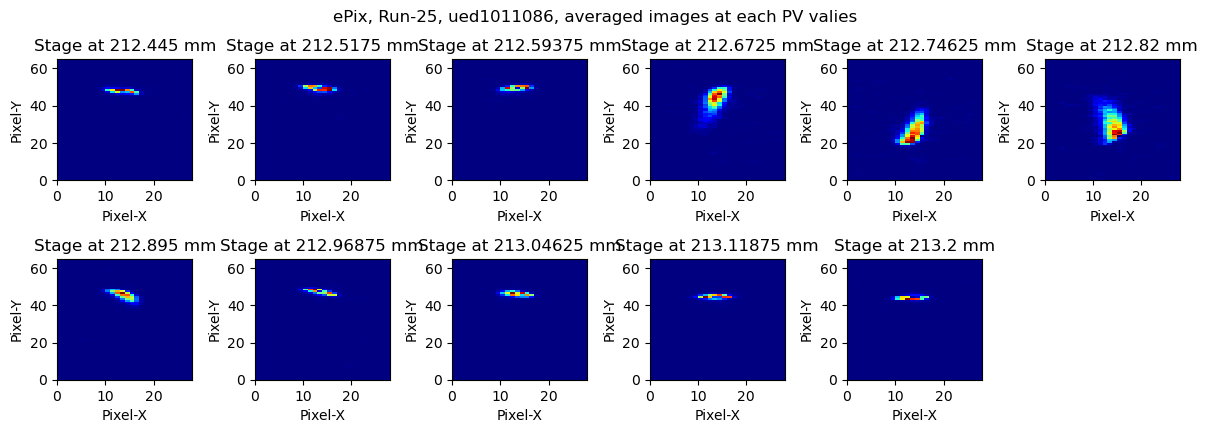

In [140]:
plt.figure(figsize=(12,8))
plt.suptitle('ePix, Run-'+str(run)+', '+str(exp)+', averaged images at each PV valies')
i_subplot = 1
for i_delay, delay in enumerate(delayss):
    if i_delay%5==0:
        plt.subplot(4,6,i_subplot)
        plt.pcolormesh(img_runs_ave[i_delay],cmap='jet')
        i_subplot = i_subplot + 1
        plt.cmap = [0,70000]
        plt.xlabel('Pixel-X')
        plt.ylabel('Pixel-Y')
        plt.title('Stage at '+str(delay)+' mm')

plt.tight_layout()
plt.show()

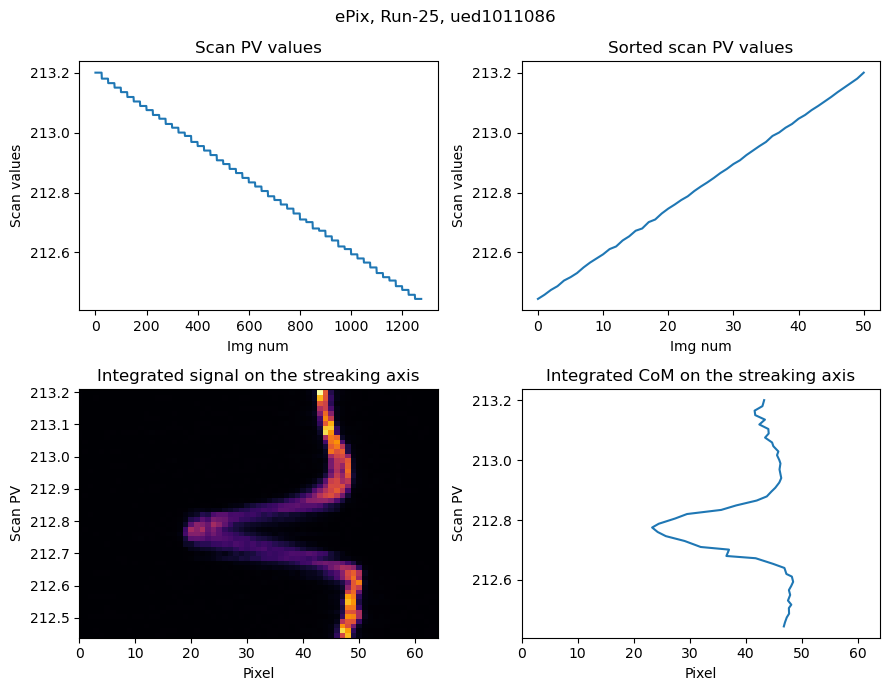

In [141]:
plt.figure(figsize=(9,7))
plt.suptitle('ePix, Run-'+str(run)+', '+str(exp))

plt.subplot(2,2,1)
plt.plot(scan_var_1_runs)
plt.xlabel('Img num');plt.ylabel('Scan values');plt.title('Scan PV values');

plt.subplot(2,2,2)
plt.plot(delayss,'-')
plt.xlabel('Img num');plt.ylabel('Scan values');plt.title('Sorted scan PV values')

plt.subplot(2,2,3)
plt.pcolormesh(np.arange(np.shape(img_inte_2_runs)[1]),delayss,img_inte_2_runs_ave,cmap='inferno')
plt.xlim([0,img_cut_shape[1]-1])
plt.title('Integrated signal on the streaking axis');
plt.xlabel('Pixel');plt.ylabel('Scan PV');# plt.colorbar()

plt.subplot(2,2,4)
plt.plot(img_inte_2_runs_coms_ave,delayss)
plt.xlim([0,img_cut_shape[1]-1])
plt.xlabel('Pixel');plt.ylabel('Scan PV');
plt.title('Integrated CoM on the streaking axis');

plt.tight_layout()
plt.show()